# Intro

Let's start again from analyzing the data. Breaking down C3S by their features that we are focusing on using:
1. m/z
2. adducts
3. mqns (42): "c", "f", "cl", "br", "i", "s", "p", "an", "cn", "ao", "co",
    "hac", "hbam", "hba", "hbdm", "hbd", "neg", "pos", "asb", "adb",
    "atb", "csb", "cdb", "ctb", "rbc", "asv", "adv", "atv", "aqv",
    "cdv", "ctv", "cqv", "r3", "r4", "r5", "r6", "r7", "r8", "r9",
    "rg10", "afr", "bfr"
4. Fingerprints
5. Polarization

We have tried Autoencoder + KMeans + GNN. The model underfit in this structure. We decided to keep the GNN constant and change the feature selection process from PCA, LDA, and Dylan's Feature selection paper

# C3S Breakdown

In [1]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import copy 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
conn = sqlite3.connect('/Users/reubensantoso/Xu_Lab_Files/Neural Network/C3S.db')
cursor = conn.cursor()
master_df = pd.read_sql_query("SELECT * FROM master", conn)
mqn_df = pd.read_sql_query("SELECT * FROM mqns", conn)
fngr_df = pd.read_sql_query("SELECT * FROM fingerprints", conn)

c3s_df = pd.merge(master_df, mqn_df, on='g_id', how='left')
c3s_df = pd.merge(c3s_df, fngr_df, on='g_id', how='left')
c3s_df = c3s_df.dropna()
conn.close()

c3s_df.head()

,g_id,name,adduct,mass,z,mz,ccs,smi,chem_class_label,src_tag,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CCSBASE_C4B6CF0FE6,1-Methylnicotinamide,[M]+,137.0715,1,137.0715,126.4,C[N+]1=CC=CC(=C1)C(=O)N,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCSBASE_D0DE2590C2,7-Methylguanosine,[M]+,298.1151,1,298.1151,166.5,CN1C=[N+](C2=C1C(=O)N=C(N2)N)[C@H]3[C@@H]([C@@...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CCSBASE_FC56BC6B13,Thiamine pyrophosphate,[M]+,425.0444,1,425.0444,182.0,CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCOP(=O)(O)OP(=...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,CCSBASE_8A71E86DA2,beta-Nicotinamide D-ribonucleotide,[M]+,335.0639,1,335.0639,165.2,C1=CC(=C[N+](=C1)[C@H]2[C@@H]([C@@H]([C@H](O2)...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CCSBASE_D4448E3E51,Androsterone,[M+H-H2O]+,273.2218,1,273.2218,166.6,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2CC[C@]4...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Regression Plotting

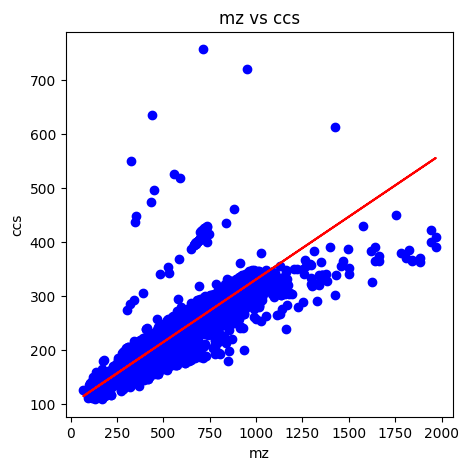

In [3]:
# Plotting all mz data against ccs
plt.figure(figsize=(5, 5))
plt.scatter(c3s_df['mz'], c3s_df['ccs'], c='blue')

m, b = np.polyfit(c3s_df['mz'], c3s_df['ccs'], 1)
plt.plot(c3s_df['mz'], m * c3s_df['mz'] + b, color='red')

plt.title('mz vs ccs')
plt.xlabel('mz')
plt.ylabel('ccs')
plt.show()

Normalizing MZ and CCS

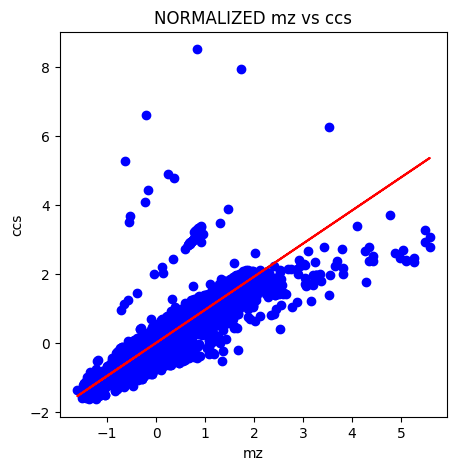

In [4]:
scaler = StandardScaler()

c3s_df_scaled = copy.deepcopy(c3s_df)
features_to_scale = ['mz', 'ccs']
data_to_scale = c3s_df_scaled[features_to_scale]

# Fit and transform the selected features
scaled_data = scaler.fit_transform(data_to_scale)
c3s_df_scaled[features_to_scale] = scaled_data

#plot
plt.figure(figsize=(5, 5))
plt.scatter(c3s_df_scaled['mz'], c3s_df_scaled['ccs'], c='blue')

m, b = np.polyfit(c3s_df_scaled['mz'], c3s_df_scaled['ccs'], 1)
plt.plot(c3s_df_scaled['mz'], m * c3s_df_scaled['mz'] + b, color='red')

plt.title('NORMALIZED mz vs ccs')
plt.xlabel('mz')
plt.ylabel('ccs')
plt.show()

## PCA on MQN

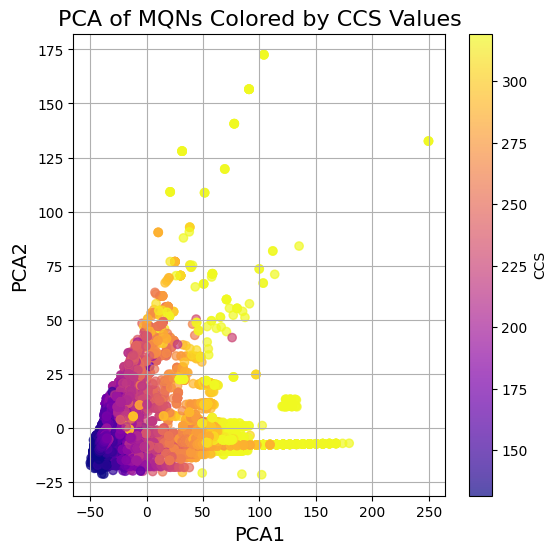

MQN Explained Variance Ratio: [0.83573233 0.08885392]
MQN Total Explained Variance: 0.924586248482643


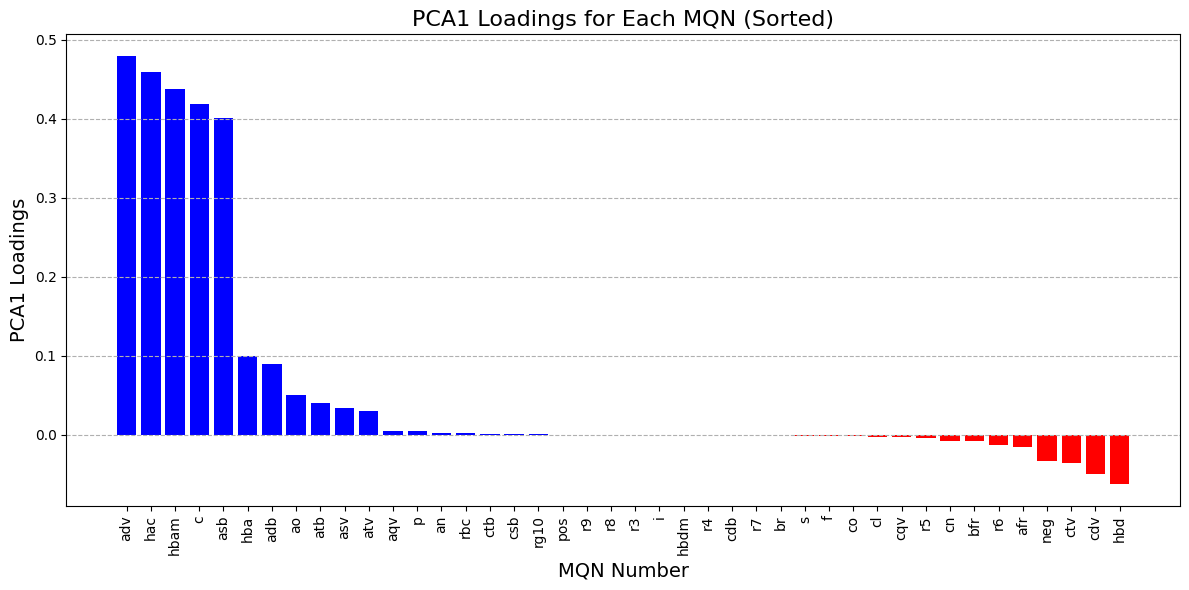

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']


In [5]:
# Create a list of column names for MQN data
mqn_columns = [
    "c", "f", "cl", "br", "i", "s", "p", "an", "cn", "ao", "co",
    "hac", "hbam", "hba", "hbdm", "hbd", "neg", "pos", "asb", "adb",
    "atb", "csb", "cdb", "ctb", "rbc", "asv", "adv", "atv", "aqv",
    "cdv", "ctv", "cqv", "r3", "r4", "r5", "r6", "r7", "r8", "r9",
    "rg10", "afr", "bfr"

]

# Extract MQN data
mqn_df = c3s_df[mqn_columns]

##### Apply PCA #####
pca_mqn = PCA(n_components=2)
principalComponents = pca_mqn.fit_transform(mqn_df)

principalDf_mqn = pd.DataFrame(data=principalComponents, columns=["PCA1", "PCA2"], index=mqn_df.index)
principalDf_mqn["CCS"] = c3s_df["ccs"]

# Adjust color range limits for better contrast
ccs_min = principalDf_mqn["CCS"].quantile(0.05)  # Set lower bound to the 5th percentile
ccs_max = principalDf_mqn["CCS"].quantile(0.95)  # Set upper bound to the 95th percentile

plt.figure(figsize=(6, 6))
plt.scatter(principalDf_mqn["PCA1"], principalDf_mqn["PCA2"], c=principalDf_mqn["CCS"], cmap="plasma", alpha=0.7, vmin=ccs_min, vmax=ccs_max)
plt.xlabel("PCA1", fontsize=14)
plt.ylabel("PCA2", fontsize=14)
plt.title("PCA of MQNs Colored by CCS Values", fontsize=16)
plt.colorbar(label="CCS")
plt.grid(True)
plt.show()

print("MQN Explained Variance Ratio:", pca_mqn.explained_variance_ratio_)
print("MQN Total Explained Variance:", sum(pca_mqn.explained_variance_ratio_))


loadings = pd.DataFrame(pca_mqn.components_, columns=mqn_columns, index=['PCA1', 'PCA2'])
pca1_loadings = loadings.loc['PCA1']  # Get PCA1 loadings (not absolute)
sorted_loadings = pca1_loadings.sort_values(ascending=False)

colors = ['red' if loading < 0 else 'blue' for loading in sorted_loadings]

plt.figure(figsize=(12, 6))
plt.bar(sorted_loadings.index, sorted_loadings.values, color=colors)
plt.xlabel("MQN Number", fontsize=14)
plt.ylabel("PCA1 Loadings", fontsize=14)
plt.title("PCA1 Loadings for Each MQN (Sorted)", fontsize=16)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis

plt.tight_layout()  #
plt.show()
print(colors)

## PCA on Adduct Encoding

In [6]:
from sklearn.preprocessing import OneHotEncoder

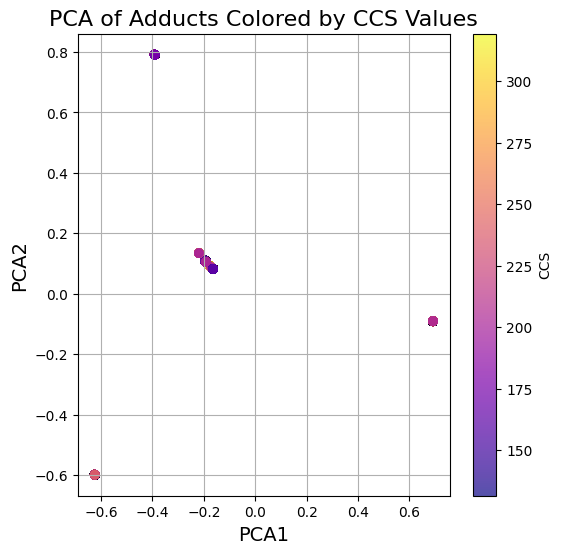

Adduct Explained Variance Ratio: [0.39752183 0.25778309]
Adduct Total Explained Variance: 0.6553049221520886


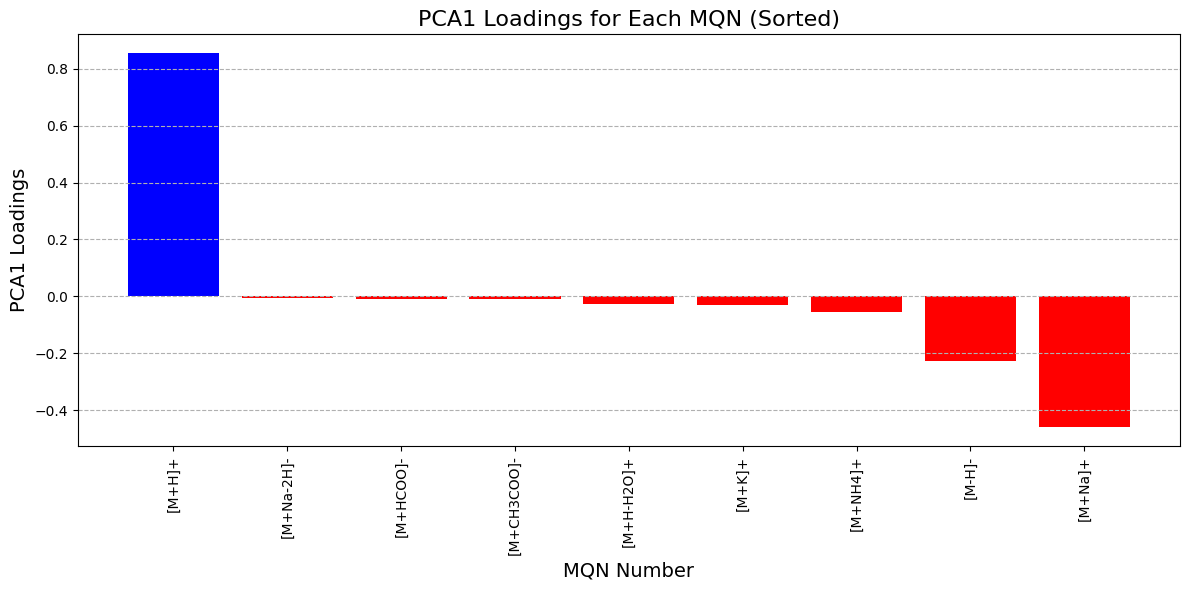

['blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']


In [7]:
adduct_groups = [
    "[M+H]+", "[M+Na]+", "[M-H]-", "[M+NH4]+", "[M+K]+",
    "[M+H-H2O]+", "[M+HCOO]-", "[M+CH3COO]-", "[M+Na-2H]-"
]

# Create OneHotEncoder
adduct_encoder = OneHotEncoder(
    sparse_output=False,
    categories=[adduct_groups],
    handle_unknown="infrequent_if_exist",
    min_frequency=10
)

# Fit and transform the adduct column
adduct_encoded = adduct_encoder.fit_transform(c3s_df[['adduct']])
adduct_encoded_df = pd.DataFrame(adduct_encoded, columns=[f"adduct_{adduct}" for adduct in adduct_encoder.categories_[0]], index=c3s_df.index)

pca_adduct = PCA(n_components=2)
principalComponents_adduct = pca_adduct.fit_transform(adduct_encoded_df)

principalDf_adduct = pd.DataFrame(data=principalComponents_adduct, columns=["PCA1", "PCA2"], index=adduct_encoded_df.index)
principalDf_adduct["CCS"] = c3s_df["ccs"]  # Add CCS values for visualization

ccs_min = principalDf_adduct["CCS"].quantile(0.05)  # Set lower bound to the 5th percentile
ccs_max = principalDf_adduct["CCS"].quantile(0.95)  # Set upper bound to the 95th percentile

plt.figure(figsize=(6, 6))
plt.scatter(principalDf_adduct["PCA1"], principalDf_adduct["PCA2"], c=principalDf_adduct["CCS"], cmap="plasma", alpha=0.7, vmin=ccs_min, vmax=ccs_max)
plt.xlabel("PCA1", fontsize=14)
plt.ylabel("PCA2", fontsize=14)
plt.title("PCA of Adducts Colored by CCS Values", fontsize=16)
plt.colorbar(label="CCS")
plt.grid(True)
plt.show()

# --- Print explained variance for Adducts ---
print("Adduct Explained Variance Ratio:", pca_adduct.explained_variance_ratio_)
print("Adduct Total Explained Variance:", sum(pca_adduct.explained_variance_ratio_))



loadings = pd.DataFrame(pca_adduct.components_, columns=adduct_groups, index=['PCA1', 'PCA2'])
pca1_loadings = loadings.loc['PCA1']  # Get PCA1 loadings (not absolute)
sorted_loadings = pca1_loadings.sort_values(ascending=False)

colors = ['red' if loading < 0 else 'blue' for loading in sorted_loadings]

plt.figure(figsize=(12, 6))
plt.bar(sorted_loadings.index, sorted_loadings.values, color=colors)
plt.xlabel("MQN Number", fontsize=14)
plt.ylabel("PCA1 Loadings", fontsize=14)
plt.title("PCA1 Loadings for Each MQN (Sorted)", fontsize=16)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis

plt.tight_layout()  #
plt.show()
print(colors)

In [8]:
c3s_df = c3s_df.join(adduct_encoded_df.set_index(c3s_df.index))
adduct_encoded_df.head()

,adduct_[M+H]+,adduct_[M+Na]+,adduct_[M-H]-,adduct_[M+NH4]+,adduct_[M+K]+,adduct_[M+H-H2O]+,adduct_[M+HCOO]-,adduct_[M+CH3COO]-,adduct_[M+Na-2H]-
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## PCA on Fingerprints

In [9]:
fngr_df = fngr_df.drop(columns = ['g_id'])

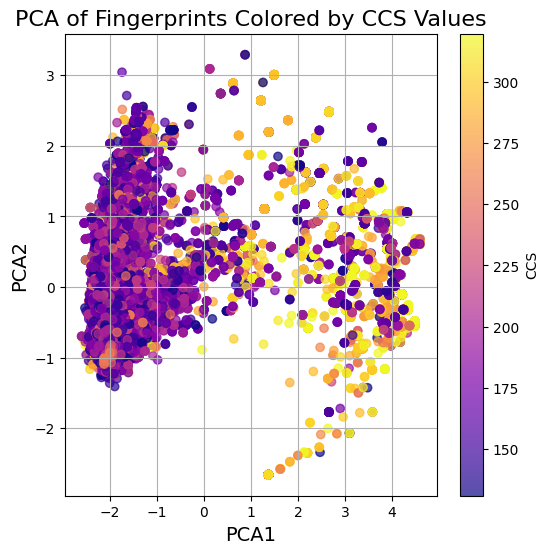

Adduct Explained Variance Ratio: [0.39752183 0.25778309]
Adduct Total Explained Variance: 0.6553049221520886


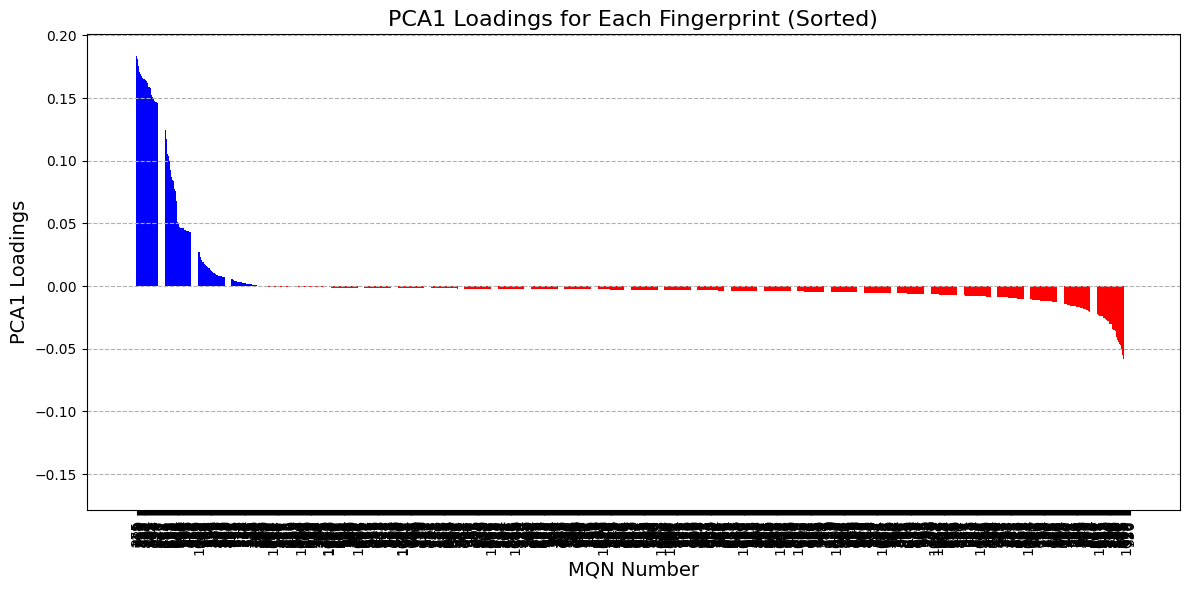

In [10]:
pca_finger = PCA(n_components=2)
principalComponents_finger = pca_finger.fit_transform(fngr_df)

principalDf_finger = pd.DataFrame(data=principalComponents_finger, columns=["PCA1", "PCA2"], index=fngr_df.index)
principalDf_finger["CCS"] = c3s_df["ccs"]  # Add CCS values for visualization

ccs_min = principalDf_finger["CCS"].quantile(0.05)  # Set lower bound to the 5th percentile
ccs_max = principalDf_finger["CCS"].quantile(0.95)  # Set upper bound to the 95th percentile

plt.figure(figsize=(6, 6))
plt.scatter(principalDf_finger["PCA1"], principalDf_finger["PCA2"], c=principalDf_finger["CCS"], cmap="plasma", alpha=0.7, vmin=ccs_min, vmax=ccs_max)
plt.xlabel("PCA1", fontsize=14)
plt.ylabel("PCA2", fontsize=14)
plt.title("PCA of Fingerprints Colored by CCS Values", fontsize=16)
plt.colorbar(label="CCS")
plt.grid(True)
plt.show()

# --- Print explained variance for Adducts ---
print("Adduct Explained Variance Ratio:", pca_adduct.explained_variance_ratio_)
print("Adduct Total Explained Variance:", sum(pca_adduct.explained_variance_ratio_))


loadings = pd.DataFrame(pca_finger.components_, columns=fngr_df.columns, index=['PCA1', 'PCA2'])
pca1_loadings = loadings.loc['PCA1']  # Get PCA1 loadings (not absolute)
sorted_loadings = pca1_loadings.sort_values(ascending=False)

colors = ['red' if loading < 0 else 'blue' for loading in sorted_loadings]

plt.figure(figsize=(12, 6))
plt.bar(sorted_loadings.index, sorted_loadings.values, color=colors)
plt.xlabel("MQN Number", fontsize=14)
plt.ylabel("PCA1 Loadings", fontsize=14)
plt.title("PCA1 Loadings for Each Fingerprint (Sorted)", fontsize=16)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis

plt.tight_layout()
plt.show()

# Building GNN - Train Set



In [11]:
print(c3s_df.shape)
print(c3s_df.columns)

(15187, 1087)
Index(['g_id', 'name', 'adduct', 'mass', 'z', 'mz', 'ccs', 'smi',
       'chem_class_label', 'src_tag',
       ...
       '1023', 'adduct_[M+H]+', 'adduct_[M+Na]+', 'adduct_[M-H]-',
       'adduct_[M+NH4]+', 'adduct_[M+K]+', 'adduct_[M+H-H2O]+',
       'adduct_[M+HCOO]-', 'adduct_[M+CH3COO]-', 'adduct_[M+Na-2H]-'],
      dtype='object', length=1087)


## Building Features

In [12]:
use_subset = False #only set true for development and debugging

if use_subset:
  c3s_df = c3s_df.sample(n=200, random_state=42)

In [13]:
features = ["mz", "adv", "hac", "hbam", "c", "asb", 'adduct_[M+H]+', 'adduct_[M+Na]+', 'adduct_[M-H]-', 'adduct_[M+NH4]+',
       'adduct_[M+K]+', 'adduct_[M+H-H2O]+', 'adduct_[M+HCOO]-',
       'adduct_[M+CH3COO]-', 'adduct_[M+Na-2H]-'] #15 features

fp_cols = list(fngr_df.columns)
features_cols = features + fp_cols
target = ["ccs"]

#c3s_df now has the full features we need for everything. Now train test split
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    c3s_df[features_cols], c3s_df[target], test_size=0.2, random_state=42
)

print("training and validation set")
print(X_train_val.shape)
print(y_train_val.shape)

print("test set")
print(X_test.shape)
print(y_test.shape)

training and validation set
(12149, 1039)
(12149, 1)
test set
(3038, 1039)
(3038, 1)


## Building Edges Knn

In [14]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [15]:
X_train_tensor = torch.tensor(X_train_val.values.astype(np.float32), dtype=torch.float)
y_train_tensor = torch.tensor(y_train_val.values.astype(np.float32), dtype=torch.float)

In [16]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric='jaccard')
knn.fit(X_train_val[fngr_df.columns])

knn_graph = knn.kneighbors_graph(fngr_df, mode='connectivity').tocoo()
edge_index_train = torch.tensor(np.array([knn_graph.row, knn_graph.col]), dtype=torch.long) #make into a numpy for faster computation

/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [17]:
# import networkx as nx #library for visualizing graphs
# from scipy.sparse import coo_matrix #library for graph matrix

# coo = coo_matrix(knn_graph)

# G = nx.Graph() #initialize multiple undirected graph
# G.add_edges_from(zip(coo.row, coo.col)) #adding the points

# # node color by chem_class_label
# chem_class = c3s_df['chem_class_label'].values
# node_color = chem_class[:len(G.nodes)]

# #create mapping
# unique_chem_classes = np.unique(chem_class)
# num_chem_classes = len(unique_chem_classes)
# cmap = plt.cm.get_cmap('viridis', num_chem_classes)  # Use a discrete colormap
# color_mapping = {chem_class: cmap(i) for i, chem_class in enumerate(unique_chem_classes)}
# node_colors = [color_mapping[chem_class] for chem_class in node_color]


# # Plot
# fig, ax = plt.subplots(figsize=(10, 8))
# pos = nx.spring_layout(G, seed=42)  # force-directed layout
# nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, ax=ax)
# edges = nx.draw_networkx_edges(G, pos, edge_color='lightgray', ax=ax)
# plt.title("Fingerprint-Based Molecular Jaccard Similarity Graph")


# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_chem_classes - 1)), ax=ax)
# cbar.set_ticks(np.arange(num_chem_classes))
# cbar.set_ticklabels(unique_chem_classes)
# cbar.set_label('Chem Class')

# plt.axis('on')
# plt.show()

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3):
        """
          Initialize the Graph Convolutional Neural Network layers with distinct number of neurons.

          Parameters:
          - hiddden_channels1: the number of neurons in the 1st hidden layer
          - hiddle_channels2: the number of neurons in the 2nd hidden layer
          - hiddle_channels3: the number of neurons in the 3rd hidden layer
        """
        super(GNN, self).__init__()
        torch.manual_seed(1234)

        # hidden = int(1.5 * input_dim)
        self.conv1 = GCNConv(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)  # Add batch normalization

        self.conv2 = GCNConv(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)

        self.conv3 = GCNConv(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)

        self.output = Linear(hidden3, 1)

        self.dropout_rates = [0.5, 0.2]


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[0], training=self.training)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[1], training=self.training)

        x = self.output(x)

        return x.squeeze()


In [19]:
def train(model, data, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #updating model parameters in epochs
    criterion = nn.MSELoss()

    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        # --- Train phase ---
        model.train() #set model for training
        optimizer.zero_grad() #Reset the gradients of all optimized torch.Tensor
        out = model(data) #Pass the 'data' object directly

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward() #back propagation
        optimizer.step() #Perform a single optimization step.
        train_loss = loss.item()
        train_history.append(train_loss)

        # --- Val phase ---
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            val_loss_item = val_loss.item()
            val_history.append(val_loss_item)

        # --- MRE calculation ---
        with torch.no_grad():
            mre_train = (
                torch.abs((out[data.train_mask] - data.y[data.train_mask]) / data.y[data.train_mask])
                .mean()
                .item()
            )
            mre_val = (
                torch.abs((val_out[data.val_mask] - data.y[data.val_mask]) / data.y[data.val_mask])
                .mean()
                .item()
            )

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss_item:.4f}")
        print(f"MRE Train: {mre_train:.4f}, MRE Val: {mre_val:.4f}")

    return train_history, val_history, model

# Example plot function to visualize the loss histories
def plot_history(histories):
    for h in histories:
        epochs = range(1, len(h['train_loss']) + 1)
        plt.plot(epochs, h['train_loss'], label=f"{h['name']} Train Loss")
        plt.plot(epochs, h['val_loss'], label=f"{h['name']} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.legend()
    plt.show()

In [20]:
from torch_geometric.data import Data
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import train_test_split
from itertools import product

data_train_val = Data(
    x=X_train_tensor,           # this contains ["mz", "adv", "hac", ..., fingerprints]
    y=y_train_tensor,           # CCS values
    edge_index=edge_index_train # edges from kNN over fingerprints - jaccard similarity
)

#Define frid Search of multiple GNN settings
#input features is 1039
learning_rates = [0.0001, 0.001, 0.01, 0.1]
hidden_layer_configs = [
    (520, 260, 5),
    (520, 260, 130),
    (128, 64, 32),
]

grid = list(product(learning_rates, hidden_layer_configs))



=== Grid 1/12 | LR=0.0001, Hidden=(520,260,5) ===
Fold 1/3


/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8099, 1])) that is different to the input size (torch.Size([8099])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4050, 1])) that is different to the input size (torch.Size([4050])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200 | Train Loss: 49103.3906, Val Loss: 50122.1953
MRE Train: 0.9975, MRE Val: 1.0063
Epoch 2/200 | Train Loss: 49102.0898, Val Loss: 49930.6406
MRE Train: 0.9975, MRE Val: 1.0040
Epoch 3/200 | Train Loss: 49098.0273, Val Loss: 49833.0352
MRE Train: 0.9974, MRE Val: 1.0029
Epoch 4/200 | Train Loss: 49095.8359, Val Loss: 49773.2539
MRE Train: 0.9974, MRE Val: 1.0021
Epoch 5/200 | Train Loss: 49094.6367, Val Loss: 49732.5078
MRE Train: 0.9974, MRE Val: 1.0017
Epoch 6/200 | Train Loss: 49093.6055, Val Loss: 49699.5039
MRE Train: 0.9974, MRE Val: 1.0013
Epoch 7/200 | Train Loss: 49088.2812, Val Loss: 49670.8906
MRE Train: 0.9973, MRE Val: 1.0009
Epoch 8/200 | Train Loss: 49089.1211, Val Loss: 49646.8594
MRE Train: 0.9973, MRE Val: 1.0006
Epoch 9/200 | Train Loss: 49087.0430, Val Loss: 49622.6016
MRE Train: 0.9973, MRE Val: 1.0003
Epoch 10/200 | Train Loss: 49084.1836, Val Loss: 49596.7422
MRE Train: 0.9972, MRE Val: 1.0000
Epoch 11/200 | Train Loss: 49082.6406, Val Loss: 49568.5273

/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8100, 1])) that is different to the input size (torch.Size([8100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4049, 1])) that is different to the input size (torch.Size([4049])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200 | Train Loss: 49035.0312, Val Loss: 50269.3203
MRE Train: 0.9975, MRE Val: 1.0064
Epoch 2/200 | Train Loss: 49033.0820, Val Loss: 50087.4570
MRE Train: 0.9975, MRE Val: 1.0042
Epoch 3/200 | Train Loss: 49029.1289, Val Loss: 49998.3398
MRE Train: 0.9974, MRE Val: 1.0032
Epoch 4/200 | Train Loss: 49027.5469, Val Loss: 49947.0586
MRE Train: 0.9974, MRE Val: 1.0026
Epoch 5/200 | Train Loss: 49025.2656, Val Loss: 49903.3516
MRE Train: 0.9974, MRE Val: 1.0021
Epoch 6/200 | Train Loss: 49024.0391, Val Loss: 49870.0039
MRE Train: 0.9973, MRE Val: 1.0017
Epoch 7/200 | Train Loss: 49020.8125, Val Loss: 49841.5820
MRE Train: 0.9973, MRE Val: 1.0013
Epoch 8/200 | Train Loss: 49019.5312, Val Loss: 49812.9062
MRE Train: 0.9973, MRE Val: 1.0010
Epoch 9/200 | Train Loss: 49017.9883, Val Loss: 49785.0586
MRE Train: 0.9973, MRE Val: 1.0006
Epoch 10/200 | Train Loss: 49013.1055, Val Loss: 49755.4062
MRE Train: 0.9972, MRE Val: 1.0003
Epoch 11/200 | Train Loss: 49015.2109, Val Loss: 49725.7305

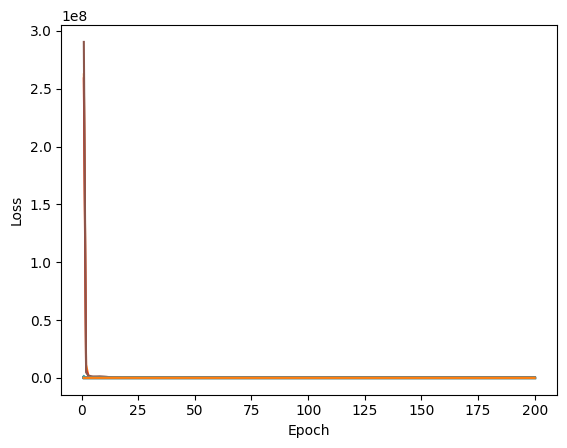

In [21]:
from sklearn.model_selection import KFold
from itertools import product
from torch_geometric.utils import subgraph

# Track best model
best_model = None
best_val_mre = float('inf')
best_train_mre = float('inf')
best_params = None

# Store all histories
all_histories = []

# Loop over grid of hyperparameters
for i, (lr, (h1, h2, h3)) in enumerate(grid):
    print(f"\n=== Grid {i+1}/{len(grid)} | LR={lr}, Hidden=({h1},{h2},{h3}) ===")

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_val_mres = []
    fold_train_mres = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(data_train_val.x)):
        print(f"Fold {fold+1}/{kf.get_n_splits()}")

        # Combine all indices and build subgraph
        all_idx = torch.tensor(train_idx.tolist() + val_idx.tolist(), dtype=torch.long)
        edge_index_sub, _ = subgraph(subset=all_idx, edge_index=data_train_val.edge_index, relabel_nodes=True)

        x_sub = data_train_val.x[all_idx]
        y_sub = data_train_val.y[all_idx]

        train_idx_new = torch.arange(len(train_idx))
        val_idx_new = torch.arange(len(train_idx), len(all_idx))

        data_fold = Data(x=x_sub, y=y_sub, edge_index=edge_index_sub)
        mask = torch.zeros(len(all_idx), dtype=torch.bool)
        data_fold.train_mask = mask.clone()
        data_fold.train_mask[train_idx_new] = True
        data_fold.val_mask = mask.clone()
        data_fold.val_mask[val_idx_new] = True

        # Train the model
        model = GNN(input_dim=data_fold.num_features, hidden1=h1, hidden2=h2, hidden3=h3).to(device)
        data_fold = data_fold.to(device)
        train_hist, val_hist, trained_model = train(model, data_fold, num_epochs=200, learning_rate=lr)

        # Inference for final fold MREs
        model.eval()
        with torch.no_grad():
            preds = model(data_fold)
            y_true = data_fold.y

            train_mre = (torch.abs(preds[data_fold.train_mask] - y_true[data_fold.train_mask]) / y_true[data_fold.train_mask]).mean().item()
            val_mre = (torch.abs(preds[data_fold.val_mask] - y_true[data_fold.val_mask]) / y_true[data_fold.val_mask]).mean().item()

        fold_train_mres.append(train_mre)
        fold_val_mres.append(val_mre)

        # Save history for plotting
        all_histories.append({
            'name': f'LR={lr}, H=({h1},{h2},{h3}), Fold {fold+1}',
            'train_loss': train_hist,
            'val_loss': val_hist
        })

    # Average MREs across folds
    avg_train_mre = sum(fold_train_mres) / len(fold_train_mres)
    avg_val_mre = sum(fold_val_mres) / len(fold_val_mres)

    print(f"Avg Train MRE: {avg_train_mre:.4f}, Avg Val MRE: {avg_val_mre:.4f}")

    if avg_val_mre < best_val_mre:
        best_val_mre = avg_val_mre
        best_train_mre = avg_train_mre
        best_model = trained_model
        best_params = {'lr': lr, 'hidden': (h1, h2, h3)}

# Final best config
print(f"\n✅ Best Config: LR={best_params['lr']}, Hidden={best_params['hidden']}")
print(f"📉 Best Train MRE: {best_train_mre:.4f}, Best Val MRE: {best_val_mre:.4f}")

# Plot all histories
plot_history(all_histories)


## Evaluation on Test Set

In [22]:
#have to retrain since above is only trained k diff models ~66% of full training data

# # === Retrain best model on full train_val set ===
# knn = NearestNeighbors(n_neighbors=5, metric='jaccard')
# knn.fit(X_train_val[fngr_df.columns])

# knn_graph = knn.kneighbors_graph(X_train_val[fngr_df.columns], mode='connectivity').tocoo()
# edge_index_full = torch.tensor(np.array([knn_graph.row, knn_graph.col]), dtype=torch.long)

# data_full = Data(
#     x=torch.tensor(X_train_val.values, dtype=torch.float),
#     y=torch.tensor(y_train_val.values, dtype=torch.float),
#     edge_index=edge_index_full
# ).to(device)

# # Build model with best hyperparameters
# model = GNN(
#     input_dim=data_full.num_features,
#     hidden1=best_params['hidden'][0],
#     hidden2=best_params['hidden'][1],
#     hidden3=best_params['hidden'][2]
# ).to(device)

# # Retrain model on all training data
# train_hist, _, best_model = train(model, data_full, num_epochs=200, learning_rate=best_params['lr'])

# # === Test set evaluation ===
# knn = NearestNeighbors(n_neighbors=5, metric='jaccard')
# knn.fit(X_test[fngr_df.columns])

# knn_graph = knn.kneighbors_graph(X_test[fngr_df.columns], mode='connectivity').tocoo()
# edge_index_test = torch.tensor(np.array([knn_graph.row, knn_graph.col]), dtype=torch.long)

# data_test = Data(
#     x=torch.tensor(X_test.values, dtype=torch.float),
#     y=torch.tensor(y_test.values, dtype=torch.float),
#     edge_index=edge_index_test
# ).to(device)

# # Evaluate best model on test set
# best_model.eval()
# with torch.no_grad():
#     test_preds = best_model(data_test)
#     epsilon = 1e-8
#     test_mre = (torch.abs(test_preds - data_test.y) / (data_test.y + epsilon)).mean().item()

# print(f"\n🏁 Final Test MRE using Best Config: {test_mre:.4f}")
